# Multi Feature Extraction

In this tutorial we will show you how to install and use the `AutonFeat` package for multi-feature extraction. We apply the package to the problem of ***time-series forecasting*** i.e. using past values of a time-series to predict future values. When featurizing time-series signals, it is often useful to extract multiple features from the same signal. For example, we may want to compute a subset of summary statistics (e.g. mean, variance, etc.) on the data. This often makes the job of the model easier in converging to a better performance metric.

Feel free to follow along in this Google Colab notebook - 

<a href="https://colab.research.google.com/github/autonlab/AutonFeat/blob/main/examples/tutorials/multi_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages

In [1]:
%%capture
!pip install git+https://github.com/autonlab/AutonFeat.git

In [2]:
%%capture
!git clone "https://github.com/autonlab/AutonFeat.git"
import sys
sys.path.append("AutonFeat")

In [3]:
import autonfeat as aft
import numpy as np
import pandas as pd

## Load Dataset

List available datasets that we can use for this tutorial:

In [4]:
print(aft.utils.datasets.list_datasets())

['airline passengers']


Load the ***Airline Passengers*** dataset:

In [5]:
air_passengers_df = aft.utils.datasets.get_dataset(name='airline passengers')
air_passengers_df['datestamp'] = pd.to_datetime(air_passengers_df['datestamp'])
air_passengers_df.drop(columns=['uid'], inplace=True)
air_passengers_df.head()

,datestamp,passengers
0,1949-01-31,112.0
1,1949-02-28,118.0
2,1949-03-31,132.0
3,1949-04-30,129.0
4,1949-05-31,121.0


Plot the time-series (it is often useful to visualize the data before we start modeling):

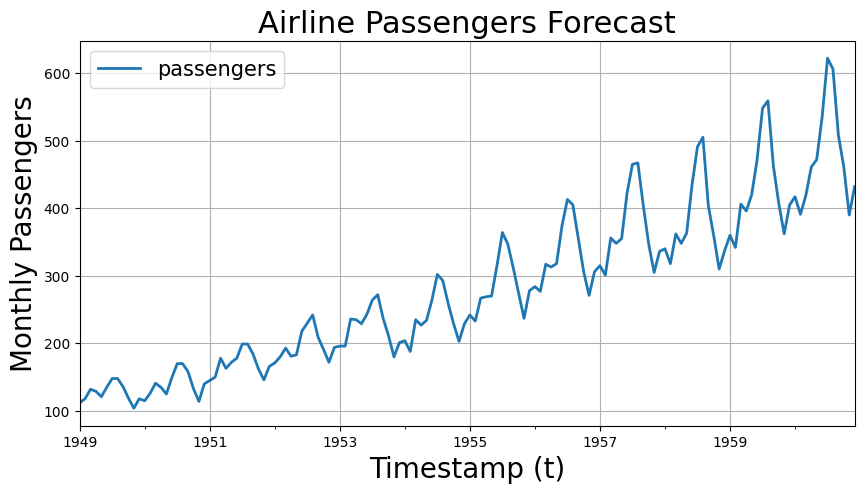

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plot_df = air_passengers_df.set_index('datestamp')

plot_df[['passengers']].plot(ax=ax, linewidth=2)
ax.set_title('Airline Passengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp (t)', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

## Preprocess Data

We can compute lag features using the preprocessing library from `AutonFeat`. This is often useful for time-series forecasting problems. We can combine this with feature extraction of summary statistics to create a rich set of features for our model (we will see this in the next section).

In [7]:
# Define the number of lagged values to include as features
lags = [1, 2, 3]

preprocessor = aft.preprocess.LagPreprocessor()

# Create lagged features
for lag in lags:
    air_passengers_df[f'passengers_lag{lag}'] = preprocessor(air_passengers_df['passengers'].values, lag=lag)

## Feature Extraction

Set the parameters of the sliding window to perform feature extraction:

- `window_size`: the size of the sliding window
- `step_size`: the stride of the sliding window
- `overflow`: what to do with the last window if it is smaller than `window_size`

In this case, we choose to use the `stop` overflow strategy which means that we will stop the sliding window if the last window is smaller than `window_size`.

In [9]:
# Sliding Window
window_size = 12
step_size = 1
sliding_window = aft.SlidingWindow(window_size=window_size, step_size=step_size, overflow='stop')

Define the features we want to extract from the time-series. We will extract the following features from the data:

- `mean`: The mean of the signal (at each window).
- `min`: The minimum value of the signal (at each window).
- `max`: The maximum value of the signal (at each window).
- `median`: The median of the signal (at each window).

In [10]:
transforms = [
    aft.MeanTransform(),
    aft.MinTransform(),
    aft.MaxTransform(),
    aft.MedianTransform(),
]

feature_names = []
for transform in transforms:
    featurizer = sliding_window.use(transform=transform)
    features = featurizer(air_passengers_df['passengers'].values)

    # We add NaNs to the end of the array to make it the same length of the original array
    features = np.append(features, np.repeat(np.nan, len(air_passengers_df) - len(features)))

    # Add the features to the dataframe
    air_passengers_df[f'passengers_{transform.get_name().lower()}'] = features
    feature_names.append(f'passengers_{transform.get_name().lower()}')

Here is what our data looks like after *preprocessing* and *feature extraction*:

In [11]:
air_passengers_df.head()

,datestamp,passengers,passengers_lag1,passengers_lag2,passengers_lag3,passengers_mean,passengers_min,passengers_max,passengers_median
0,1949-01-31,112.0,NaN,NaN,NaN,126.666667,104.0,148.0,125.0
1,1949-02-28,118.0,112.0,NaN,NaN,126.916667,104.0,148.0,125.0
2,1949-03-31,132.0,118.0,112.0,NaN,127.583333,104.0,148.0,127.5
3,1949-04-30,129.0,132.0,118.0,112.0,128.333333,104.0,148.0,127.5
4,1949-05-31,121.0,129.0,132.0,118.0,128.833333,104.0,148.0,130.5


Lets see what the ***mean*** feature looks like:

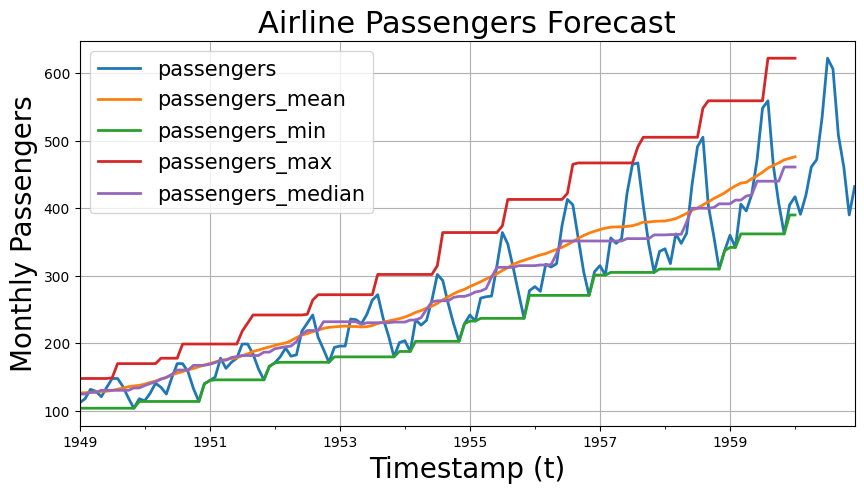

In [12]:
# Plot the mean feature with the original data
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plot_df = air_passengers_df.set_index('datestamp')
plot_cols = ['passengers'] + feature_names
plot_df[plot_cols].plot(ax=ax, linewidth=2)
ax.set_title('Airline Passengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp (t)', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Feature extraction often results in a decrease in the number of data points. In our case, we chose to handle *overflow* using the `stop` strategy as specified in the `SlidingWindow`. We can see this reduction in the number of data points below:

In [13]:
# Drop rows with missing values due to the lag
print(f'Dataframe contained {air_passengers_df.shape[0]} samples')
air_passengers_df.dropna(inplace=True)
print(f'Dataframe now contains {air_passengers_df.shape[0]} samples')

Dataframe contained 144 samples
Dataframe now contains 130 samples


Finally, we split our data into training and test sets.

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_df, test_df = train_test_split(air_passengers_df, test_size=0.2, shuffle=False)

# Define the target variable
target = 'passengers'

# Define the features to use
features = ['passengers_lag1', 'passengers_lag2', 'passengers_lag3'] + feature_names

# Create the feature matrix and target vector
X_train = train_df[features].values
y_train = train_df[target].values.reshape(-1, 1)

X_test = test_df[features].values
y_test = test_df[target].values.reshape(-1, 1)

print('Training set sizes - ', X_train.shape, y_train.shape)
print('Test set sizes - ', X_test.shape, y_test.shape)

Training set sizes -  (104, 7) (104, 1)
Test set sizes -  (26, 7) (26, 1)


## Fit Model

We will be using an autoregressive model for time series forecasting. Autoregressive models are a class of models that use past values to predict future values, then use the predicted values to predict even further into the future. One of the simplest autoregressive models is a linear regression model. We will be using the `LinearRegression` class from `sklearn` to fit a linear regression model to our data.

In [15]:
%%capture
from sklearn.linear_model import LinearRegression

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

## Evaluate Model

Remember that we adjusted the target values when we performed feature extraction? Well we can now use the remaining data points to evaluate our model. We will be using the ***mean absolute error*** (MAE) as our evaluation metric. The MAE is defined as:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

where $y_i$ is the actual value of the time-series at time $i$ and $\hat{y}_i$ is the predicted value of the time-series at time $i$.

In [16]:
from sklearn.metrics import mean_absolute_error

# Predict on the test set
y_pred = model.predict(X_test)

We can evaluate the results both quantitatively and qualitatively. First, lets look at the MAE:

In [17]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 28.03


If we compare this error to that of single-feature extraction (see the single feature extraction tutorial), we are able to get a better performance with multi-feature extraction as the $MAE = 32$ for single-feature extraction and the $MAE = 28$ for multi-feature extraction.

Next lets plot the actual values of the time-series against the predicted values:

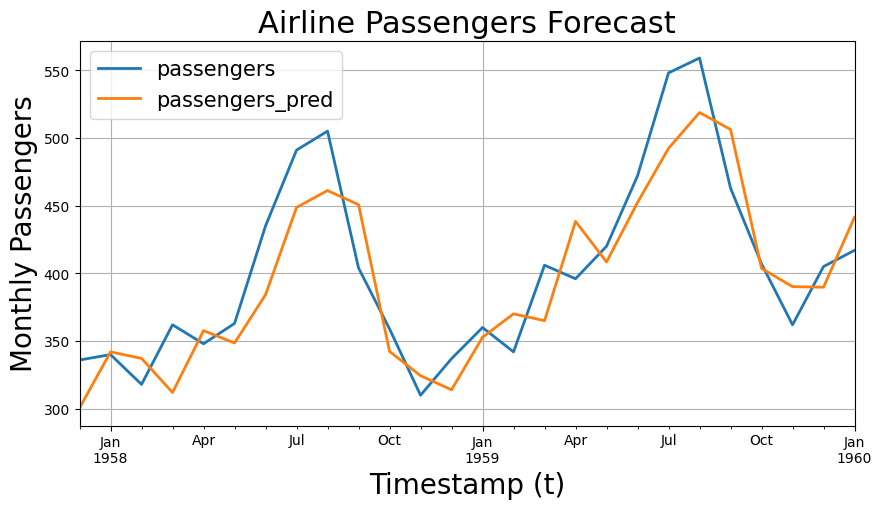

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
plot_df = test_df.set_index('datestamp')
plot_df['passengers_pred'] = y_pred

plot_df[['passengers', 'passengers_pred']].plot(ax=ax, linewidth=2)
ax.set_title('Airline Passengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp (t)', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


Here is what it looks like with respect to the original time-series:

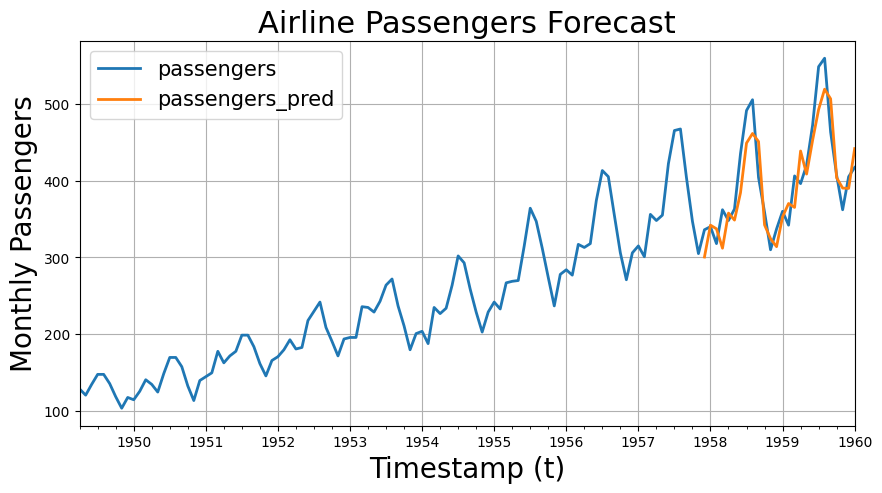

In [19]:
# Plot the training and test sets
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
test_df['passengers_pred'] = y_pred
plot_df = pd.concat([train_df, test_df]).set_index('datestamp')

plot_df[['passengers', 'passengers_pred']].plot(ax=ax, linewidth=2)
ax.set_title('Airline Passengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp (t)', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


If you enjoy using `AutonFeat`, please consider starring the [repository](https://github.com/autonlab/AutonFeat) ⭐️.